In [1]:
import numpy as np
import h5py as hp
import PyNAFF as pnf
import sys
from matplotlib import pyplot as plt
import seaborn as sbs
from FITX import fit_risetime
sbs.set(rc={'figure.figsize':(8.3,5.2),
            'text.usetex':True,
           'font.family':'serif',
           'font.size':20,
           'axes.linewidth':2,
           'lines.linewidth':3,
           'legend.fontsize':16,
           'legend.numpoints':1,},
        style='white',
        palette='colorblind',
        context='talk')
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Reading files

In [2]:
def read_data_point(real, imag, folder):
    folder
    postfix = '(dQre={0:.3f},dQim={1:.3f})'.format(real*1e3, imag*1e3)
    bunch_filename = folder+'BM'+postfix
    bunch_file = hp.File(bunch_filename+'.h5')
    mean_x = bunch_file['Bunch']['mean_x'][:]
    mean_xp = bunch_file['Bunch']['mean_xp'][:]

    epsn_x = bunch_file['Bunch']['epsn_x'][:]
    mean_y = bunch_file['Bunch']['mean_y'][:]
    mean_yp = bunch_file['Bunch']['mean_yp'][:]
    epsn_y = bunch_file['Bunch']['epsn_y'][:]
    n_turns = bunch_file['Bunch']['mean_x'].shape[0]
    bunch_file.close()
    return mean_x, mean_xp, mean_y, mean_yp, epsn_x, epsn_y, n_turns

## Octupoles Stability Diagram comparison with simple impedance model simulations

In [3]:
def is_stable(folder, real, imag):
    mean_x, mean_xp, mean_y, mean_yp, epsn_x, epsn_y, n_turns = read_data_point(real, imag, folder)
    mean_x = mean_x[:32000]
    mean_xp = mean_x[:32000]
    is_stable_x, is_stable_y = False, False
    beta_x = 140
    beta_y = 142
    signal_x = np.sqrt(mean_x**2+(beta_x*mean_xp)**2)
    signal_y = np.sqrt(mean_y**2+(beta_y*mean_yp)**2)
    smoothing_window_size=512
    min_level = 10 * np.max(signal_x[:1000])
    rx = fit_risetime(
        signal_x, min_level=min_level, 
        smoothing_window_size=smoothing_window_size
    ) 
    min_level = 10 * np.max(signal_y[:1000])
    ry = fit_risetime(
        signal_y, min_level=min_level, 
        smoothing_window_size=smoothing_window_size
    ) 
    
    threshold = 1e-5
    min_growth_rate = 1/(2*np.pi*32000)
    if (np.isnan(rx) or rx < min_growth_rate):
        is_stable_x = True
    if (np.isnan(ry) or ry < min_growth_rate):
        is_stable_y = True
    if max(abs(mean_x)) > threshold:
        is_stable_x = False
    if max(abs(mean_y)) > threshold:
        is_stable_y = False
            
    return is_stable_x, is_stable_y

In [4]:
%%time
def read_scan_data(folder):
    dQcoh_real = np.load(folder+'dQcoh_real.npy')
    dQcoh_imag = np.load(folder+'dQcoh_imag.npy')
    points_x = []
    points_y = []
    points_x_stable = []
    points_y_stable = []
    points_x_stable_vert = []
    points_y_stable_vert = []
    is_stable_x = []
    is_stable_y = []
    err_x = []
    err_y = []
    err_x_vert = []
    err_y_vert = []
    for r in dQcoh_real:
        for i in dQcoh_imag:
            mean_x, mean_xp, mean_y, mean_yp, epsn_x, epsn_y, n_turns = read_data_point(r, i, folder)
            points_x.append(r)
            points_y.append(i)
            try:
                is_stable_x.append(is_stable(folder, r, i)[0])
                is_stable_y.append(is_stable(folder, r, i)[1])
                if is_stable_x[-1]:
                    points_x_stable.append(r)
                    points_y_stable.append(i)
                    err_x.append(1/(n_turns))
                    err_y.append(1/(n_turns))
                if is_stable_y[-1]:
                    points_x_stable_vert.append(r)
                    points_y_stable_vert.append(i)
                    err_x_vert.append(1/(n_turns))
                    err_y_vert.append(1/(n_turns))
            except:
                is_stable_x.append(1)
                is_stable_y.append(1)
    return points_x, err_x, is_stable_x, points_y, err_y, is_stable_y, points_x_stable, points_y_stable, points_x_stable_vert, points_y_stable_vert, err_x_vert, err_y_vert

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [5]:
def plot_stability_scan(folder_data, folder_theory, folder_results, folder_sim):
    Q_s = 0.001
    data = read_scan_data(folder_data)
    points_x, err_x, is_stable_x, points_y, err_y, is_stable_y, points_x_stable, points_y_stable, points_x_stable_vert, points_y_stable_vert, err_x_vert, err_y_vert = data
    np.set_printoptions(precision=3)
#     sbs.set(rc={'figure.figsize':(8.3,5.2)}, style='white', palette='colorblind', context='talk')
#     fig, (ax1) = plt.subplots(1, 2, sharey=True)
    fig, ax1 = plt.subplots(1, 1)
#     ax1.set_title('Horizontal plane')
#     ax2.set_title('Vertical plane')
    ax1.set_xlabel('$\Re{\Delta Q_{coh}}/10^{-3}$')
    ax1.set_ylabel('$\Im{\Delta Q_{coh}}/10^{-3}$')
#     ax2.set_xlabel('$\Re{\Delta Q_{coh}}/\delta Q_{rms}$')
#     dQre = np.load(folder_theory + 'dQre.npy')
#     dQim = np.load(folder_theory + 'dQim.npy')
    ax1.scatter(np.array(points_x_stable)/Q_s, np.array(points_y_stable)/Q_s, marker='.', color='r')#,
#                  xerr=0*np.array(err_x)/Q_s, yerr=0*np.array(err_y)/Q_s, capsize=2)
#     ax2.errorbar(np.array(points_x_stable_vert)/Q_s, np.array(points_y_stable_vert)/Q_s, fmt='r.',
#                  xerr=0.25*np.array(err_x_vert)/Q_s, yerr=0.25*np.array(err_y_vert)/Q_s, capsize=2)
#     ax2.plot(3*dQcoh_vert.real/Q_s, 3*dQcoh_vert.imag/Q_s, linewidth=2, color='black')
#     ax1.plot((dQcoh_vert.real)/Q_s, dQcoh_vert.imag/Q_s, linewidth=2, color='black')
#     ax1.plot(dQre/Q_s, dQim/Q_s, linewidth=2, color='black')
#     dQcoh = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams/pulsed_elens/horizontal.npy')
#     dQcoh = np.load(folder_theory+'horizontal.npy')
#     ax1.plot(2.5*dQcoh.real/1e-3, 2.5*dQcoh.imag/1e-3, color='black')
    dQr = np.load(folder_theory+'dQre.npy')
    dQi = np.load(folder_theory+'dQim.npy')
    ax1.plot(dQr/1e-3, dQi/1e-3, c='black')
#     dQre = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/DC-elens(r=1.0)/dQre.npy')
#     dQim = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/DC-elens(r=1.0)/dQim.npy')
    dQre = np.load(folder_sim+'dQre.npy')
    dQim = np.load(folder_sim+'dQim.npy')
    dQre = dQre[~np.isnan(dQim)]
    dQim = dQim[~np.isnan(dQim)]
    dQre = dQre[dQim != 0]
    dQim = dQim[dQim != 0]
    ax1.plot(dQre/1e-3, dQim, marker='o', color='navy')
    
    ax1.legend(('Dispersion relation', 'Stability diagram (sim)', 'Stable points (sim)'), loc='upper left')
#     ax2.legend(('Dispersion relation', 'simulation'))
#     ax1.set_xlim(min(points_x)/Q_s, max(points_x)/Q_s)
    ax1.set_xlim(-1.001, 1.001)
#     ax2.set_xlim(min(points_x)/Q_s, max(points_x)/Q_s)
#     ax2.set_xlim(-0.001, 0.35)
#     ax1.set_ylim(-0.1*Q_s, max(points_y)/Q_s)
    ax1.set_ylim(-0.001, 0.45)
#     ax2.set_ylim(-0.1*Q_s, max(points_y)/Q_s)
#     ax2.set_ylim(-0.1*Q_s, 0.1)
    plt.tight_layout()
    plt.savefig(folder_results+'octupolestemp.png')
    plt.savefig(folder_results+'octupolestemp.pdf')  
    plt.show() 
    return 0

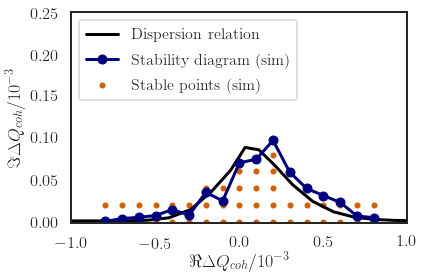

CPU times: user 3.94 s, sys: 56 ms, total: 4 s
Wall time: 3.99 s


0

In [11]:
%%time
folder_data = '/home/vgubaidulin/PhD/Data_server/Stability_scans/HLLHC/octupoles/'
folder_theory = '/home/vgubaidulin/PhD/Data/Stability_diagrams/LHC_octupoles/'
folder_results = '/home/vgubaidulin/PhD/Results/SD_scans/LHC/octupoles/'
folder_sim = '/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/LHC_octupoles/'
plot_stability_scan(folder_data, folder_theory, folder_results, folder_sim)

[0.0e+00 2.0e-05 4.0e-05 6.0e-05 8.0e-05 1.0e-04 1.2e-04 1.4e-04 1.6e-04
 1.8e-04 2.0e-04 2.2e-04 2.4e-04 2.6e-04 2.8e-04 3.0e-04 3.2e-04 3.4e-04
 3.6e-04]


/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in square
  if __name__ == '__main__':
/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in add
  if __name__ == '__main__':


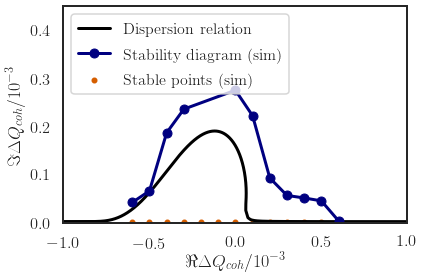

CPU times: user 4.5 s, sys: 35.8 ms, total: 4.54 s
Wall time: 4.53 s


0

In [8]:
%%time
folder_data = '/home/vgubaidulin/PhD/Data_server/Stability_scans/FCC/pelens2/'
folder_theory = '/home/vgubaidulin/PhD/Data/Stability_diagrams/pelens/'
folder_results = '/home/vgubaidulin/PhD/Results/SD_scans/FCC/pelens/'
folder_sim = '/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/pelens/'
plot_stability_scan(folder_data, folder_theory, folder_results, folder_sim)

/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in add
  
/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in add
  import sys


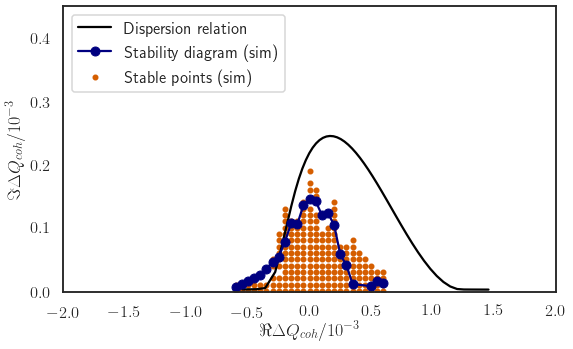

CPU times: user 37.1 s, sys: 820 ms, total: 37.9 s
Wall time: 38 s


0

In [242]:
%%time
folder_data = '/home/vgubaidulin/PhD/Data_server/Stability_scans/FCC/DC-elens(dQ=0.002)/'
folder_theory = '/home/vgubaidulin/PhD/Data/Stability_diagrams/DC-elens(r=1.0)/'
folder_results = '/home/vgubaidulin/PhD/Results/SD_scans/FCC/DC-elens(dQ=0.002)/'
folder_sim = '/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/DC-elens(dQ=0.002)/'
plot_stability_scan(folder_data, folder_theory, folder_results, folder_sim)

/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in square
  if __name__ == '__main__':
/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in add
  if __name__ == '__main__':


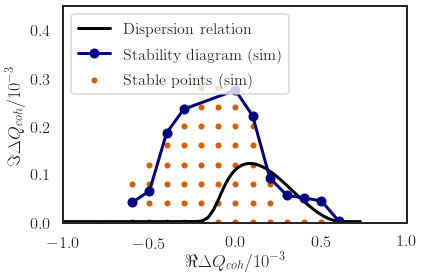

CPU times: user 5.9 s, sys: 622 ms, total: 6.52 s
Wall time: 7.53 s


0

In [16]:
%%time
folder_data = '/home/vgubaidulin/PhD/Data_server/Stability_scans/FCC/pelens(dQ=0.001)/'
folder_theory = '/home/vgubaidulin/PhD/Data/Stability_diagrams/pelens/'
folder_results = '/home/vgubaidulin/PhD/Results/SD_scans/FCC/pelens/'
folder_sim = '/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/pelens/'
plot_stability_scan(folder_data, folder_theory, folder_results, folder_sim)

/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in add
  
/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in add
  import sys


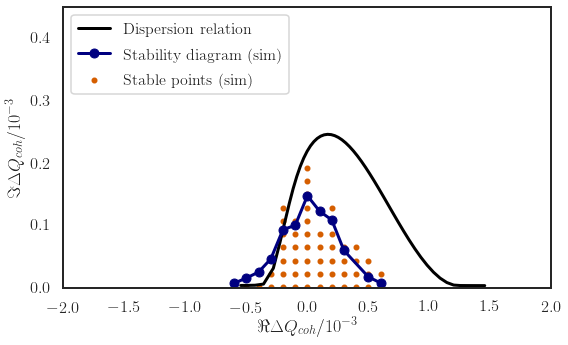

CPU times: user 25.9 s, sys: 769 ms, total: 26.7 s
Wall time: 28.5 s


0

In [25]:
%%time
folder_data = '/home/vgubaidulin/PhD/Data_server/Stability_scans/FCC/DC-elens_2D/'
folder_theory = '/home/vgubaidulin/PhD/Data/Stability_diagrams/DC-elens(r=1.0)/'
folder_results = '/home/vgubaidulin/PhD/Results/SD_scans/FCC/DC-elens_2D/'
folder_sim = '/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/DC-elens_2D/'
plot_stability_scan(folder_data, folder_theory, folder_results, folder_sim)

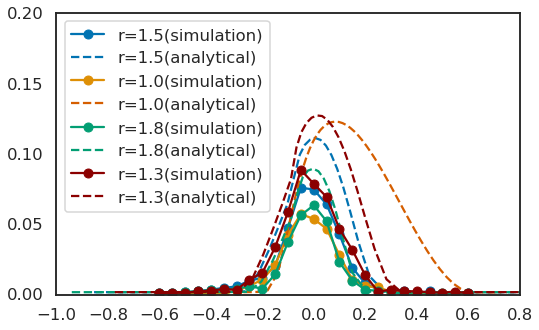

In [101]:
fig, ax1 = plt.subplots(1, 1)
dQre = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/DC-elens(r=1.5)/dQre.npy')
dQim = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/DC-elens(r=1.5)/dQim.npy')
dQre = dQre[~np.isnan(dQim)]
dQim = dQim[~np.isnan(dQim)]
ax1.plot(dQre/1e-3, dQim, marker='o')
dQcoh = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams/DC-elens(r=1.5)/horizontal.npy')
ax1.plot(dQcoh.real/1e-3, dQcoh.imag/1e-3, color='b', linestyle='--')
dQre = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/DC-elens/dQre.npy')
dQim = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/DC-elens/dQim.npy')
dQre = dQre[~np.isnan(dQim)]
dQim = dQim[~np.isnan(dQim)]
ax1.plot(dQre/1e-3, dQim, marker='o')
dQre = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams/DC-elens/matched/dQre.npy')
dQim = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams/DC-elens/matched/dQim.npy')
ax1.plot(dQre/1e-3, dQim/1e-3, color='r', linestyle='--')
dQre = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/DC-elens(r=1.8)/dQre.npy')
dQim = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/DC-elens(r=1.8)/dQim.npy')
dQre = dQre[~np.isnan(dQim)]
dQim = dQim[~np.isnan(dQim)]
ax1.plot(dQre/1e-3, dQim, marker='o')
dQcoh = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams/DC-elens(r=1.8)/horizontal.npy')
ax1.plot(dQcoh.real/1e-3, dQcoh.imag/1e-3, color='g', linestyle='--')

dQre = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/DC-elens(r=1.3)/dQre.npy')
dQim = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/DC-elens(r=1.3)/dQim.npy')
dQre = dQre[~np.isnan(dQim)]
dQim = dQim[~np.isnan(dQim)]
ax1.plot(dQre/1e-3, dQim, marker='o', c='darkred')
dQcoh = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams/DC-elens(r=1.3)/horizontal.npy')
ax1.plot(dQcoh.real/1e-3, dQcoh.imag/1e-3, color='darkred', linestyle='--')
plt.legend(('r=1.5(simulation)','r=1.5(analytical)',
            'r=1.0(simulation)', 'r=1.0(analytical)',
            'r=1.8(simulation)', 'r=1.8(analytical)',
            'r=1.3(simulation)', 'r=1.3(analytical)'),
           loc='upper left')
plt.xlim(-1.0, 0.8)
plt.ylim(-1e-3, 0.2)
plt.show()

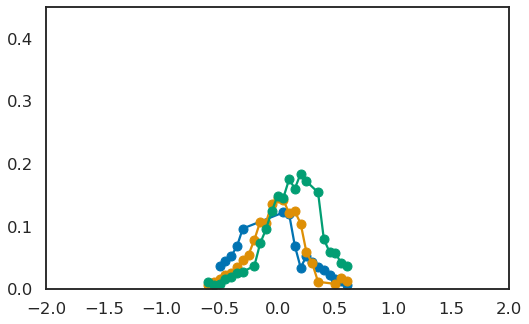

In [229]:
fig, ax1 = plt.subplots(1, 1)

dQre = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/octupoles/dQre.npy')
dQim = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/octupoles/dQim.npy')
dQre = dQre[~np.isnan(dQim)]
dQim = dQim[~np.isnan(dQim)]
dQre = dQre[dQim != 0]
dQim = dQim[dQim != 0]
ax1.plot(dQre/1e-3, dQim, marker='o')

dQre = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/DC-elens(dQ=0.002)/dQre.npy')
dQim = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/DC-elens(dQ=0.002)/dQim.npy')
dQre = dQre[~np.isnan(dQim)]
dQim = dQim[~np.isnan(dQim)]
dQre = dQre[dQim != 0]
dQim = dQim[dQim != 0]
ax1.plot(dQre/1e-3, dQim, marker='o')



dQre = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/combox2/dQre.npy')
dQim = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/combox2/dQim.npy')
dQre = dQre[~np.isnan(dQim)]
dQim = dQim[~np.isnan(dQim)]
dQre = dQre[dQim != 0]
dQim = dQim[dQim != 0]
ax1.plot(dQre/1e-3, dQim, marker='o')

plt.xlim(-2.0, 2.0)
plt.ylim(-1e-3, 0.45)
plt.show()

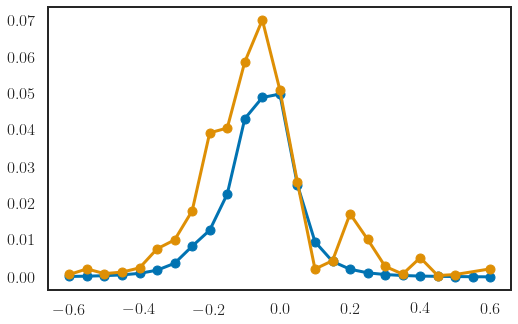

In [55]:
fig, ax1 = plt.subplots(1, 1)

dQre = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/rfq/dQre.npy')
dQim = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/rfq/dQim.npy')
dQre = dQre[~np.isnan(dQim)]
dQim = dQim[~np.isnan(dQim)]
dQre = dQre[dQim != 0]
dQim = dQim[dQim != 0]
ax1.plot(dQre/1e-3, dQim, marker='o')

dQre = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/rfq+octupoles/dQre.npy')
dQim = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/rfq+octupoles/dQim.npy')
dQre = dQre[~np.isnan(dQim)]
dQim = dQim[~np.isnan(dQim)]
dQre = dQre[dQim != 0]
dQim = dQim[dQim != 0]
ax1.plot(dQre/1e-3, dQim, marker='o')